## Analysis for glutamate imaging

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums, spearmanr, f_oneway, kruskal
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(font_scale=2, style='ticks')

In [2]:
from pathlib import Path
vol_file = '../Voltron_data/SnFR_Log_DRN_Exp.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/SnFRData/'
dir_folder = Path(dat_folder)

## Gain Adaptation

In [3]:
frame_rate = 30
t_pre = 20
t_post = 30 # 1 sec according to frame-rate
t_flat = 15
t_valid = 16
color_list = ['k', 'r', 'b']

In [4]:
vel_list = []
power_list = []
power_con_list = []
fish_list = []

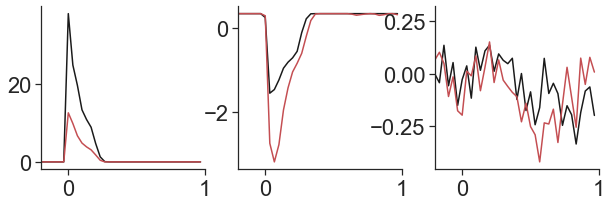

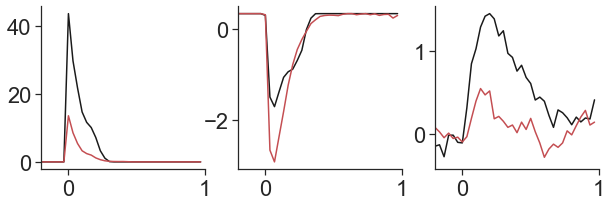

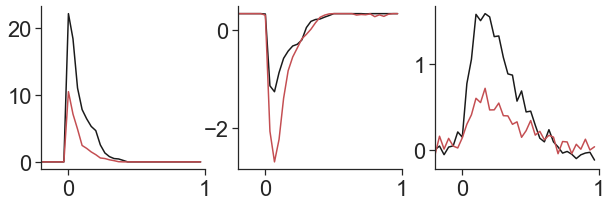

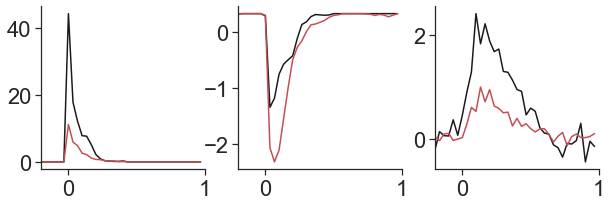

In [7]:
for index, row in dat_xls_file.iterrows():
    if row['type'] != 'tph2':
        continue
    if row['task'] != 'Gain adaptation':
        continue
    if row['area'] != 'GABA':
        continue
    folder = row['folder']
    fish = row['fish']
    rootDir = row['rootDir']
    swm_dir = dat_folder+f'{folder}/{fish}/swim/'
    img_dir = rootDir+f'{folder}/{fish}/Registered'
    dff_dir = dat_folder+f'{folder}/{fish}/Data/'
    
    frame_stimParams = np.load(swm_dir+'frame_stimParams.npy', allow_pickle=True)[()];
    frame_swim_tcourse = np.load(swm_dir+"frame_swim_tcourse_series.npy", allow_pickle=True)[()];
    rawdata = np.load(swm_dir+"rawdata.npy", allow_pickle=True)[()]
    swimdata = np.load(swm_dir+"swimdata.npy", allow_pickle=True)[()]
    reclen=len(swimdata['fltCh1'])
    frame_tcourse=np.zeros((reclen,))
    frame=np.where(np.diff((rawdata['ch3']>3).astype('int'))==1)[0]
    for t in range(len(frame)-1):
        frame_tcourse[frame[t]:frame[t+1]]=t
    swim_start = frame_tcourse[np.where(swimdata['swimStartT']>0)[0]].astype('int')
    swim_end = frame_tcourse[np.where(swimdata['swimEndT']>0)[0]].astype('int')
    # collect trial within t-pre, and t-post valid range
    swim_end   = swim_end[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
    swim_start = swim_start[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
    valid = np.diff(swim_start) > t_post
    swim_end = swim_end[:-1][valid]
    swim_start = swim_start[:-1][valid]
    
    swim_list = []
    for ntype in range(2):
        _ = swim_start[np.where(frame_stimParams[2,swim_start]==ntype+1)[0]]
        valid = np.diff(_) > t_post
        if valid.sum()<10:
            continue
        swim_list.append(_[:-1][valid])
    
    if len(swim_list)<2:
        continue

    # image
    ave = np.load(dff_dir+'ave_img.npy')
    # get dff data
    _ = np.load(dff_dir+'components.npz');
    A_ = _['A_']
    C_ = _['C_']
    dFF_ = C_.T
    n_pix = dFF_.shape[-1]

    dff_list = []
    pswim_list = []
    vis_list = []
    num_swim_list = []
    t_len = int(t_pre+t_post)
    for nn_, nswim in enumerate(swim_list):
        num_swim = len(nswim)
        num_swim_list.append(num_swim)
        dff_ = np.zeros((num_swim, t_len, n_pix))
        pswim_ = np.zeros((num_swim, t_len))
        vis_ = np.zeros((num_swim, t_len))
        for ns, s in enumerate(nswim):
            l_swim = frame_swim_tcourse[1,(s-t_pre):(s+t_post)]
            r_swim = frame_swim_tcourse[2,(s-t_pre):(s+t_post)]
            pswim_[ns] = np.sqrt(l_swim**2 + r_swim**2)*100000 # TK: 10000
            dff_[ns] = dFF_[(s-t_pre):(s+t_post), :] - dFF_[(s-t_flat):s, :].mean(axis=0, keepdims=True)
            vis_[ns] = -frame_stimParams[0,(s-t_pre):(s+t_post)]*10000
        
        valid_ = pswim_[:, -t_valid:].sum(axis=-1)==0
        # valid_ = valid_ & (pswim_.max(axis=-1)<20) # results hold as it changed to 100
        valid_ = valid_ & (pswim_[:, :t_pre].sum(axis=-1)==0)
        valid_ = valid_ & ((vis_[:, :t_pre]<0).sum(axis=-1)==0)
        
        if valid_.sum()>10:
            dff_list.append(dff_[valid_])
            pswim_list.append(pswim_[valid_])
            vis_list.append(vis_[valid_])
    
    if len(dff_list)<2:
        continue

    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax = ax.flatten()
    color_list = ['k', 'r', 'b']
    for n in range(2):
        ax[0].plot(np.arange(-t_pre, t_post)/frame_rate, pswim_list[n].mean(axis=0), color_list[n])
        ax[1].plot(np.arange(-t_pre, t_post)/frame_rate, vis_list[n].mean(axis=0), color_list[n])
        ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n].mean(axis=0).mean(axis=-1)*100, color_list[n])
    #     ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n][:,:,10].mean(axis=0)*100, color_list[n])
    sns.despine()
    ax[0].set_xlim([-0.2, 1.0])
    ax[1].set_xlim([-0.2, 1.0])
    ax[2].set_xlim([-0.2, 1.0])
    # plt.savefig('../Plots/glu/example_fish_random_delay.svg')
    plt.show()

['04102019', 'Fish1-1']
['04102019', 'Fish1-2']


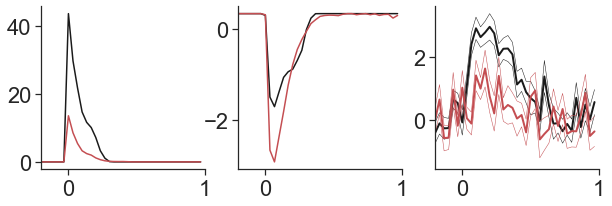

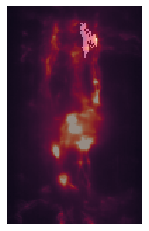

['04102019', 'Fish1-3']


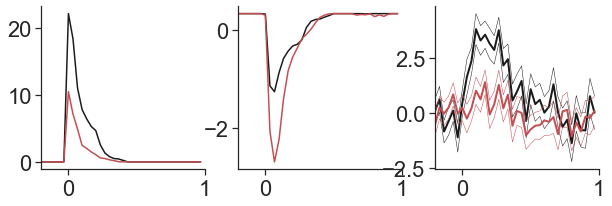

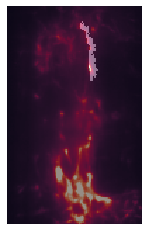

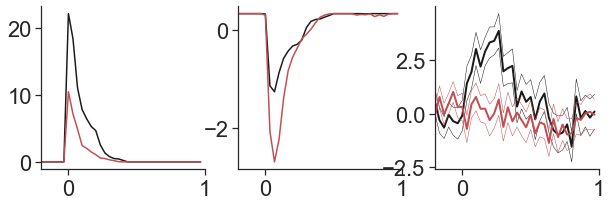

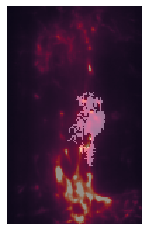

['04102019', 'Fish1-4']


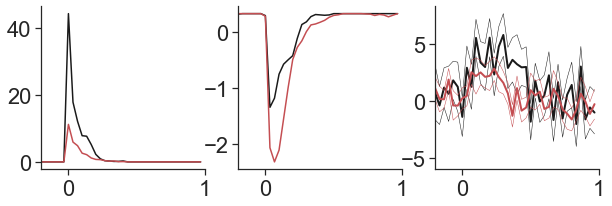

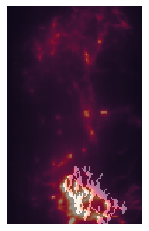

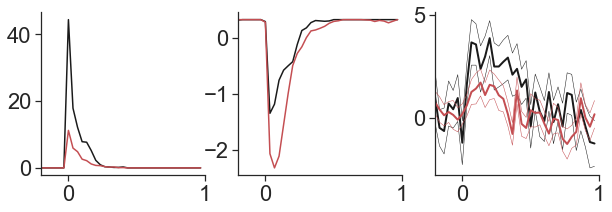

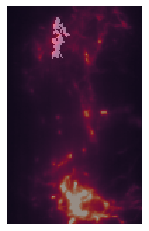

In [15]:
for index, row in dat_xls_file.iterrows():
    if row['type'] != 'tph2':
        continue
    if row['task'] != 'Gain adaptation':
        continue
    if row['area'] != 'GABA':
        continue
    folder = row['folder']
    fish = row['fish']
    rootDir = row['rootDir']
    swm_dir = dat_folder+f'{folder}/{fish}/swim/'
    img_dir = rootDir+f'{folder}/{fish}/Registered'
    dff_dir = dat_folder+f'{folder}/{fish}/Data/'
    
    frame_stimParams = np.load(swm_dir+'frame_stimParams.npy', allow_pickle=True)[()];
    frame_swim_tcourse = np.load(swm_dir+"frame_swim_tcourse_series.npy", allow_pickle=True)[()];
    rawdata = np.load(swm_dir+"rawdata.npy", allow_pickle=True)[()]
    swimdata = np.load(swm_dir+"swimdata.npy", allow_pickle=True)[()]
    reclen=len(swimdata['fltCh1'])
    frame_tcourse=np.zeros((reclen,))
    frame=np.where(np.diff((rawdata['ch3']>3).astype('int'))==1)[0]
    for t in range(len(frame)-1):
        frame_tcourse[frame[t]:frame[t+1]]=t
    swim_start = frame_tcourse[np.where(swimdata['swimStartT']>0)[0]].astype('int')
    swim_end = frame_tcourse[np.where(swimdata['swimEndT']>0)[0]].astype('int')
    # collect trial within t-pre, and t-post valid range
    swim_end   = swim_end[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
    swim_start = swim_start[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
    valid = np.diff(swim_start) > t_post
    swim_end = swim_end[:-1][valid]
    swim_start = swim_start[:-1][valid]
    
    swim_list = []
    for ntype in range(3):
        _ = swim_start[np.where(frame_stimParams[2,swim_start]==ntype+1)[0]]
        valid = np.diff(_) > t_post
        if valid.sum()<10:
            continue
        swim_list.append(_[:-1][valid])
    
    if len(swim_list)<2:
        continue
    if np.concatenate(swim_list).shape[0]<30:
        continue

    # image
    ave = np.load(dff_dir+'ave_img.npy')
    # get dff data
    _ = np.load(dff_dir+'components.npz');
    A_ = _['A_']
    C_ = _['C_']
    dFF_ = C_.T
    n_pix = dFF_.shape[-1]

    dff_list = []
    pswim_list = []
    vis_list = []
    num_swim_list = []
    t_len = int(t_pre+t_post)
    for nn_, nswim in enumerate(swim_list):
        num_swim = len(nswim)
        num_swim_list.append(num_swim)
        dff_ = np.zeros((num_swim, t_len, n_pix))
        pswim_ = np.zeros((num_swim, t_len))
        vis_ = np.zeros((num_swim, t_len))
        for ns, s in enumerate(nswim):
            l_swim = frame_swim_tcourse[1,(s-t_pre):(s+t_post)]
            r_swim = frame_swim_tcourse[2,(s-t_pre):(s+t_post)]
            pswim_[ns] = np.sqrt(l_swim**2 + r_swim**2)*100000 # TK: 10000
            dff_[ns] = dFF_[(s-t_pre):(s+t_post), :] - dFF_[(s-t_flat):s, :].mean(axis=0, keepdims=True)
            vis_[ns] = -frame_stimParams[0,(s-t_pre):(s+t_post)]*10000
        
        valid_ = pswim_[:, -t_valid:].sum(axis=-1)==0
        # valid_ = valid_ & (pswim_.max(axis=-1)<20) # results hold as it changed to 100
        valid_ = valid_ & (pswim_[:, :t_pre].sum(axis=-1)==0)
        valid_ = valid_ & ((vis_[:, :t_pre]<0).sum(axis=-1)==0)
        
        if valid_.sum()>10:
            dff_list.append(dff_[valid_])
            pswim_list.append(pswim_[valid_])
            vis_list.append(vis_[valid_])
    
    if len(dff_list)<2:
        continue

#     fig, ax = plt.subplots(1, 3, figsize=(10, 3))
#     ax = ax.flatten()
#     color_list = ['k', 'r', 'b']
#     for n in range(3):
#         ax[0].plot(np.arange(-t_pre, t_post)/frame_rate, pswim_list[n].mean(axis=0), color_list[n])
#         ax[1].plot(np.arange(-t_pre, t_post)/frame_rate, vis_list[n].mean(axis=0), color_list[n])
#         ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n].mean(axis=0).mean(axis=-1)*100, color_list[n])
#     #     ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n][:,:,10].mean(axis=0)*100, color_list[n])
#     sns.despine()
#     ax[0].set_xlim([-0.2, 1.0])
#     ax[1].set_xlim([-0.2, 1.0])
#     ax[2].set_xlim([-0.2, 1.0])
#     # plt.savefig('../Plots/glu/example_fish_random_delay.svg')
#     plt.show()

    print([folder, fish])
    n_c = C_.shape[0]
    valid_c = np.zeros(n_c).astype('bool')
    x, y = ave.shape
    for m in range(n_c):
        p_vec = np.ones(t_pre+t_post)
        for n_t in range(t_pre+t_post):
            _, p = ranksums(*[list(dff_list[i][:, n_t, m]) for i in range(2)])
            p_vec[n_t] = p
#         print((p_vec[t_pre:]<0.05).mean())

        if ((p_vec[:t_pre]>0.05).mean()>0.9) and ((p_vec[t_pre:]<0.05).mean()>=0.3):
            valid_c[m] = True
            fig, ax = plt.subplots(1, 3, figsize=(10, 3))
            ax = ax.flatten()
            color_list = ['k', 'r', 'b']
            for n in range(2):
                mean_ = np.mean(dff_list[n][:,:,m], axis=0)*100
                sem_ = sem(dff_list[n][:,:,m], axis=0)*100
                ax[0].plot(np.arange(-t_pre, t_post)/frame_rate, pswim_list[n].mean(axis=0), color_list[n])
                ax[1].plot(np.arange(-t_pre, t_post)/frame_rate, vis_list[n].mean(axis=0), color_list[n])
                ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, mean_, color_list[n], lw=2)
                ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, mean_+sem_, color_list[n], lw=0.5)
                ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, mean_-sem_, color_list[n], lw=0.5)
            sns.despine()
            ax[0].set_xlim([-0.2, 1.0])
            ax[1].set_xlim([-0.2, 1.0])
            ax[2].set_xlim([-0.2, 1.0])
            # plt.savefig('../Plots/glu/example_fish_random_delay.svg')
            plt.show()
            
            plt.imshow(ave, vmax=np.percentile(ave, 99))
            plt.imshow(A_[:, m].reshape(y, x).T>0, cmap=plt.cm.gray, alpha=0.4)
            plt.axis('off')
            plt.show()